# Fixing parts of a tree

In this notebook I create a simple dataset with known ground-truth and train a brush model, then I fix parts of the model and move it to another site where the data has some distribution shifts that can be learned.

By fixing parts of the structure we enable transfer learning and we can keep original weights to understand the new relationships between previous models and new ones.

In [1]:
from pybrush import BrushRegressor
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# --- 1. Generate base dataset (site A) ---
n_samples = 500

# Three features: X1, X2, X3
X_train = np.random.randn(n_samples, 3)

# Conditional relationship:
y_train = np.array([
    5 * x[0] if x[2] > 0 else -3 * x[1]
    for x in X_train
])

# --- 2. Generate shifted dataset (site B) ---
np.random.seed(42)
X_test = np.random.randn(n_samples, 3)

# Introduce a covariate shift:
# scale and translate the first two features
X_test[:, 0] = X_test[:, 0] * 1.5 + 2

# Conditional relationship with same logic but added shift
y_test = np.array([
    5 * x[0] if x[2] > 0 else -6 * x[1]
    for x in X_test
])

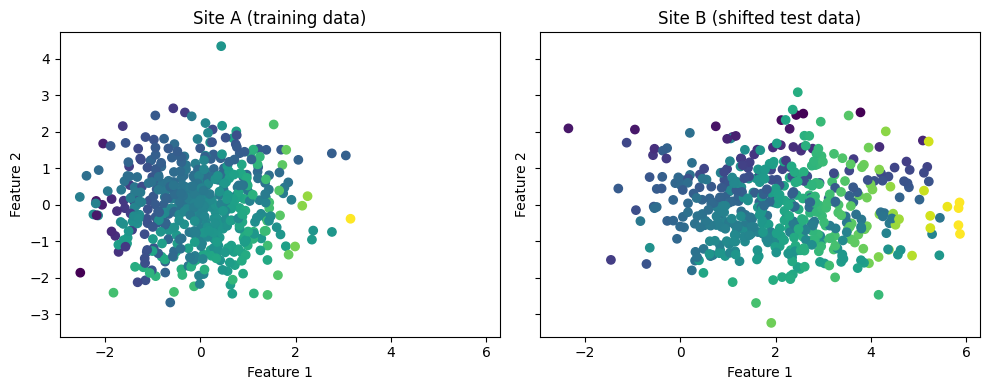

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis")
axs[0].set_title("Site A (training data)")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")

axs[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="viridis")
axs[1].set_title("Site B (shifted test data)")
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

In [4]:
# import and make a regressor
est = BrushRegressor(
    functions=['SplitBest','Mul','Add','Sub'],
    max_depth=5,
    max_size=20,
    max_gens=10,
    start_from_decision_trees=True,
    constants_simplification=False,
    inexact_simplification=False,
    verbosity=1
)

est.fit(X_train,y_train)

print('score train:', est.score(X_train,y_train))
print('score test: ', est.score(X_test,y_test))

Completed 100% [====================]
score train: 0.45095834153429726
score test:  0.12659082293924162


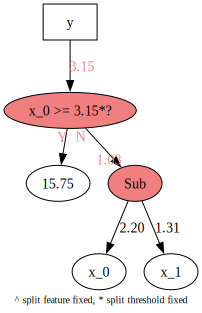

In [5]:
# locking the best estimator (visualizing what we have locked) 
est.best_estimator_.program.lock_nodes(2, keep_leaves_unlocked=True, keep_current_weights=True)

model = est.best_estimator_.get_model("dot")
graphviz.Source(model)

Completed 100% [====================]
score train: 0.3294429188771656
score test:  0.396896318305067


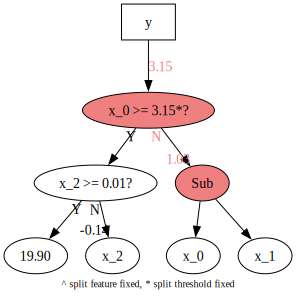

In [6]:
# locking the structure and using partial_fit

# increasing it so we have more flexibility
est.max_depth = 8
est.max_size = 30 

est.partial_fit(X_test, y_test, 
                lock_nodes_depth=2, keep_leaves_unlocked=True, keep_current_weights=True)

print('score train:', est.score(X_train,y_train))
print('score test: ', est.score(X_test,y_test))

model = est.best_estimator_.get_model("dot")
graphviz.Source(model)